The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


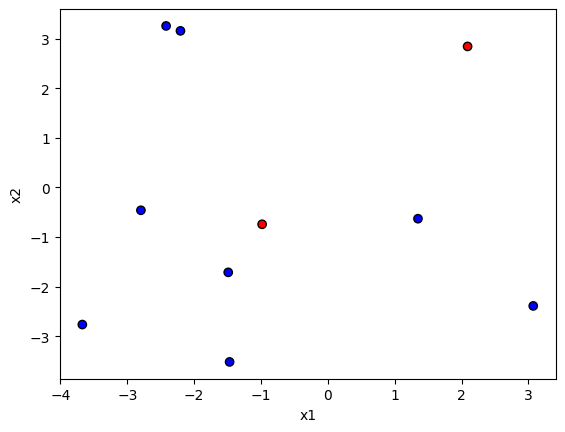

In [6]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

# Define GP Model
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel

## Clustering and Boundaries
import numpy as np
import matplotlib.pyplot as plt
import alphashape
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import random


%matplotlib inline
%load_ext autoreload
%autoreload 2


'''
Arbitrary example for classification
The algorithm runs in 2 steps : 2 Class classification(Amorphous vs Crystalline) --> 3 Class classification (Monoclinic vs orthorhombic vs tetragonal)

'''
# Define ground truth function (unknow for optimizer)
def black_box_2C(x):
    x1, x2 = float(x[0]), float(x[1])
    if (-2 <= x1 <= 0 and -1 <= x2 <= +1) or (2 <= x1 <= 4 and 2 <= x2 <= 4):
        return 1
    return 0

# Initial samples
np.random.seed(0)
train_x = -4 + 8 * torch.rand(10, 2)
train_y = torch.tensor([black_box_2C(x) for x in train_x], dtype=torch.long)

plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y, edgecolors='k', cmap="bwr")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


## iteration for 2class optimization
train_x_2c = train_x
train_y_2c = train_y

n_iter = 20
training_iter = 50

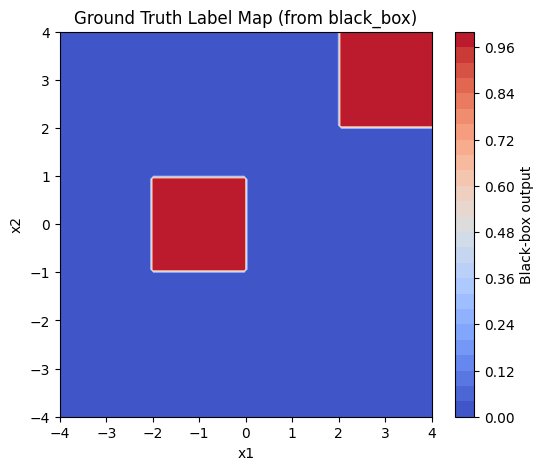

In [7]:
# Specifing the area of optimization 
test_d1 = np.linspace(-4, 4, 100)
test_d2 = np.linspace(-4, 4, 100)

test_x1_2c, test_x2_2c = np.meshgrid(test_d1, test_d2)
test_x1_2c, test_x2_2c = torch.Tensor(test_x1_2c), torch.Tensor(test_x2_2c)

test_x_2c = torch.cat((test_x1_2c.view(-1,1), test_x2_2c.view(-1,1)),dim=1)
test_labels = torch.tensor([black_box_2C(x) for x in test_x_2c], dtype=torch.float)
test_labels = test_labels.view(test_x1_2c.shape)

plt.figure(figsize=(6, 5))
plt.contourf(test_x1_2c.numpy(), test_x2_2c.numpy(), test_labels.numpy(), cmap="coolwarm", levels=25)
plt.colorbar(label="Black-box output")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Ground Truth Label Map (from black_box)")
plt.show()

In [ ]:
# Simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            MaternKernel(batch_shape=torch.Size((num_classes,))),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# GP to acquisition

def run_sweeps(train_x,train_y,test_x,training_iter,func,lr=0.1,num_samples=256):
    # Train GP model for each iteration
    likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
    model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
    
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).mean()
        loss.backward()
        if i % 5 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.mean().item(),
                model.likelihood.second_noise_covar.noise.mean().item()
            ))
        optimizer.step()

    # Acquisition function optimization
    model.eval()
    likelihood.eval()
    

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_dist = model(test_x)  # MultitaskMultivariateNormal
        num_samples = num_samples

        # Sampling latent function( shape : [num_samples, num_classes, num_points] )
        pred_samples = test_dist.sample(torch.Size([num_samples])).exp()

        # # Normalize the class probabilities
        prob_samples = pred_samples / pred_samples.sum(1, keepdim=True)

        # Average over samples → [num_classes, num_points]
        probs = prob_samples.mean(dim=0)

        if func == "most_unprobable":
        # Uncertainty: distance from 0.5
            uncertainty = torch.abs(probs - 0.5)[1,:]
            query_idx = torch.argmin(uncertainty)
        elif func == "entropy":
            uncertainty = -torch.sum(probs * torch.log(probs + 1e-10), dim=0) 
            query_idx = torch.argmax(uncertainty)
    return likelihood, probs, uncertainty, query_idx

# 2C Classification with GPC
def C2_GPC(n_iter, train_x_2c, train_y_2c, test_x_2c, training_iter, func="most_unprobable", lr=0.1, num_samples=256):
    for iteration in range(n_iter):

        likelihood, probs, uncertainty, query_idx = run_sweeps(
            train_x_2c, train_y_2c, test_x_2c, training_iter,
            func=func, lr=lr, num_samples=num_samples
        )

        x_next = test_x_2c[query_idx]
        y_next = torch.tensor([black_box_2C(x_next)], dtype=torch.long)

        # Append Data
        train_x_2c = torch.cat([train_x_2c, x_next.unsqueeze(0)], dim=0)
        train_y_2c = torch.cat([train_y_2c, y_next], dim=0)

        # Visualization
        plt.figure(figsize=(6, 5))
        contour = plt.contourf(
            test_x1_2c.numpy(), test_x2_2c.numpy(),
            probs[1, :].view(100, 100).numpy(), cmap="bwr", levels=100, alpha=0.6
        )
        plt.colorbar(contour, label="Predicted Probability (Class 1)")
        plt.scatter(train_x_2c[:, 0], train_x_2c[:, 1], c=train_y_2c, cmap="bwr", edgecolors='k', label="Train points")
        plt.scatter(x_next[0].item(), x_next[1].item(), c='gold', edgecolors='black', s=100, marker='*', label="Next sample")
        plt.title(f"Iteration {iteration+1}")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend()
        plt.tight_layout()
        plt.show()
    return likelihood, probs, uncertainty, train_x_2c, train_y_2c

In [ ]:
# Define boundaries for 2C classification
def define_boundaries(probs, test_x_2c):
    test_mask = probs[1,:] >= 0.5
    test_x1_selected = test_x_2c[test_mask][:, 0]
    test_x2_selected = test_x_2c[test_mask][:, 1]

    points = np.vstack([test_x1_selected, test_x2_selected]).T

    ## Cluster the points using DBSCAN
    clustering = DBSCAN(eps=0.5, min_samples=10).fit(points)
    labels = clustering.labels_
    unique_labels = set(labels)
    print(f"Detected {len(unique_labels) - (1 if -1 in labels else 0)} regions")

    colors = ['blue', 'green', 'purple', 'orange']

    plt.figure(figsize=(6, 6))
    alphas = []

    for idx, label in enumerate(unique_labels):

        if label == -1:
            continue  # noise 제외

        region_points = points[labels == label]

        alpha = alphashape.alphashape(region_points, alpha=0.1)
        alphas.append(alpha)

        # Visualization 
        plt.scatter(region_points[:, 0], region_points[:, 1], s=5, alpha=0.4, color=colors[idx % len(colors)], label=f'Region {label}')
        plt.plot(*alpha.exterior.xy, color='black', linewidth=1)

    plt.legend()
    plt.title("Uniform Sampling per Alpha Region")
    plt.grid(True)
    plt.show()    
    return alphas 

# Define the smallest square that can contain the alpha shape
def smallest_square(alphas, i):
    alpha = alphas[i]
    min_x1, min_x2, max_x1, max_x2 = alpha.bounds

    width = max_x1 - min_x1
    height = max_x2 - min_x2

    side_length = max(width, height)

    center_x = (min_x1 + max_x1) / 2
    center_y = (min_x2 + max_x2) / 2

    square_min_x1 = center_x - side_length / 2
    square_max_x1 = center_x + side_length / 2
    square_min_x2 = center_y - side_length / 2
    square_max_x2 = center_y + side_length / 2

    return square_min_x1, square_max_x1, square_min_x2, square_max_x2


# Define the black box function for 3C classification
def black_box_3c(x1, x2):
    diag = x1 + x2

    if -2 < x1 < 0 and -1 < x2 < 1:
        # Split diag ∈ (-3, 1) into 3 regions
        if diag < -1.6667:
            return 0
        elif diag < -0.3333:
            return 1
        else:
            return 2

    elif 2 < x1 < 4 and 2 < x2 < 4:
        # Split diag ∈ (4, 8) into 3 regions
        if diag < 5.3333:
            return 0
        elif diag < 6.6667:
            return 1
        else:
            return 2

    else:
        return 3  
    
# Reclassifying the trained data from 2C to 3C
def ClassifyTrainedData_2Dto3D(train_x_2c, train_y_2c, threshold = 0.5):
    train_mask = train_y_2c >= threshold
    train_x_selected = train_x_2c[train_mask]
    train_y_selected = torch.tensor([black_box_3c(x[0].item(), x[1].item()) for x in train_x_selected])
    plt.figure(figsize=(6, 5))
    plt.scatter(train_x_selected[:, 0], train_x_selected[:, 1], c=train_y_selected, cmap='viridis', s=10)
    plt.colorbar(label='Diagonal Region Label')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Diagonal 3-Way Split in Two Rectangles")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return train_x_selected, train_y_selected

# Reclassifying the trained data from 2C to 3C
def ClassifyTestData_2Dto3D(train_x_selected,square_min_x1, square_max_x1, square_min_x2, square_max_x2 ,alphas,i=0):
    
    train_x_3c = []
    for x in train_x_selected:
        point_to_check = Point(x[0], x[1])
        if alphas[i].contains(point_to_check):
            train_x_3c.append(x)
    train_y_3c_o = torch.tensor([black_box_3c(x[0].item(), x[1].item()) for x in train_x_3c]).long() 
    train_x_3c_o = torch.stack(train_x_3c).float()

    test_d1 = np.linspace(square_min_x1, square_max_x1, 20)
    test_d2 = np.linspace(square_min_x2, square_max_x2, 20)

    test_x1_3c, test_x2_3c = np.meshgrid(test_d1, test_d2)
    test_x1_3c, test_x2_3c = torch.Tensor(test_x1_3c), torch.Tensor(test_x2_3c)

    test_x_3c = torch.cat((test_x1_3c.view(-1,1), test_x2_3c.view(-1,1)),dim=1)
    labels = []
    for x1, x2 in zip(test_x1_3c.view(-1), test_x2_3c.view(-1)):
        labels.append(black_box_3c(x1.item(), x2.item()))

    labels = torch.tensor(labels).view(test_x1_3c.shape)

    # test_y = test_labels.view(-1)
    plt.contourf(test_x1_3c.numpy(), test_x2_3c.numpy(), labels.numpy(), cmap='viridis', s=10)

    return train_x_3c_o, train_y_3c_o, test_x1_3c, test_x2_3c, test_x_3c


In [ ]:
# 3C Classification with GPC
def C3_GPC(n_iter, train_x_3c,train_y_3c,test_x1_3c,test_x2_3c,test_x_3c,training_iter,func="entropy",lr=0.1,num_samples=256):
    for iteration in range(n_iter):

        likelihood, probs, uncertainty, query_idx = run_sweeps(train_x_3c,train_y_3c,test_x_3c,training_iter,func="entropy",lr=0.1,num_samples=256)

        x_next = test_x_3c[query_idx]
        y_next = torch.tensor(black_box_3c(x_next[0], x_next[1]))
        y_next = torch.round(y_next).long().squeeze()
        num_classes = likelihood.num_classes
        print(x_next, y_next, "number of classes = ",likelihood.num_classes)

        # Append Data
        train_x_3c = torch.cat([train_x_3c, x_next.unsqueeze(0)], dim=0)
        train_y_3c = torch.cat([train_y_3c, y_next.unsqueeze(0)], dim=0)

        # Visualization
        fig, ax = plt.subplots(1, num_classes, figsize=(15, 5))
        levels = np.linspace(0, 1.05, 20)

        for i in range(num_classes):
            im = ax[i].contourf(
                test_x1_3c.numpy(), test_x2_3c.numpy(),
                probs[i, :].view(20, 20).numpy(),
                levels=levels, cmap="coolwarm"
            )
            fig.colorbar(im, ax=ax[i])
            ax[i].set_title(f"Probabilities: Class {i}", fontsize=16)
            ax[i].set_xlabel("x1")
            ax[i].set_ylabel("x2")
            
            # Star = Next point for analysis 
            ax[i].scatter(x_next[0].item(), x_next[1].item(), c='gold', edgecolors='black', s=120, marker='*', label="Next sample")
        plt.tight_layout()
        plt.show()


In [ ]:
# 2Class Classification
likelihood, probs, uncertainty, train_x_2c, train_y_2c = C2_GPC(n_iter, train_x_2c, train_y_2c, test_x_2c, training_iter)

In [ ]:
# define boundaries
alphas = define_boundaries(probs, test_x_2c)

# define smallest square
square_min_x1, square_max_x1, square_min_x2, square_max_x2 = smallest_square(alphas,i=0)

# Classify Trained data into 3 classes
train_x_selected, train_y_selected = ClassifyTrainedData_2Dto3D(train_x_2c,train_y_2c)

# Classify the entire data into 3 classes
train_x_3c_o, train_y_3c_o, test_x1_3c, test_x2_3c, test_x_3c = ClassifyTestData_2Dto3D(train_x_selected,square_min_x1, square_max_x1, square_min_x2, square_max_x2, alphas,i=0)

# not to overwrite original data
train_x_3c = train_x_3c_o
train_y_3c = train_y_3c_o

# 3 Class classification
C3_GPC(n_iter, train_x_3c,train_y_3c,test_x1_3c,test_x2_3c,test_x_3c,training_iter,func="entropy",lr=0.1,num_samples=256)
